# Lasso implementation using ADMM (Alternating Direction Method of Multipliers)

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1


Bad key ""backend" on line 1 in
/Users/masui/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.2.1/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def show_plot(coef, value, coef_expected = None, value_expected = None, suptitle=None):
    # Plot signal and result
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(coef, label='original')
    if coef_expected is not None:
        plt.plot(coef_expected, label='expected')    
    plt.title('coeficients')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(value, label='original')
    if value_expected is not None:
        plt.plot(value_expected, label='expected')        
    
    plt.title('value')
    plt.legend()
    plt.grid()
    
    if suptitle is not None:
        plt.suptitle(suptitle)    

    plt.tight_layout()    
    if suptitle is not None:
        plt.subplots_adjust(top=0.85)

## Generate sparce signal and apply random-linear transform

In [3]:
# fix the seed of random
np.random.seed(0)

In [4]:
# Generate signal
idx = np.random.randint(0, 1000, 20)
signal = np.zeros(1000)
signal[idx] = np.random.normal(0.0, 1.0, 20)

In [5]:
# Generate observation matrix(random) and observation result
X = np.random.normal(0.0, 1.0, (100, 1000))
y = X.dot(signal)

X_test = np.random.normal(0.0, 1.0, (20, 1000))
y_test = X_test.dot(signal)

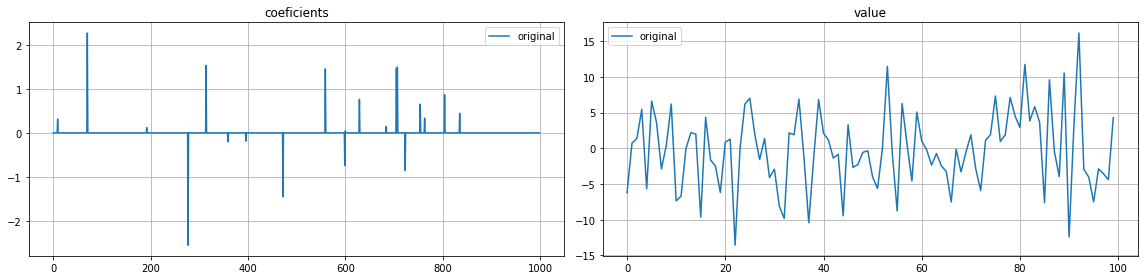

In [6]:
# Plot signal and result
show_plot(signal, y)

## Compare implementations

In [7]:
# constants
alpha = 0.1

In [8]:
import sys
sys.path.append('..')

from sklearn.linear_model import Lasso
from spmimage.linear_model import LassoADMM

/Users/masui/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/masui/.pyenv/versions/3.7.3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.coordinate_descent module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


ModuleNotFoundError: No module named 'sklearn.externals.joblib'

In [ ]:
def get_signal(model, X, y):
    model.fit(X, y)
    return model.coef_, model.predict(X)

## LASSO coordinate descent (sklearn implementation)

In [ ]:
%%time
model = Lasso(alpha=alpha)
lasso_signal, lasso_predict = get_signal(model, X, y)

In [ ]:
# Plot signal and result (sklearn)
show_plot(signal, y, lasso_signal, lasso_predict, 'LASSO coordinate descent')

## LASSO ADMM

In [ ]:
%%time
model_admm = LassoADMM(alpha=alpha)
lasso_admm_signal, lasso_admm_predict = get_signal(model_admm, X, y)

In [ ]:
# Plot signal and result (ADMM)
show_plot(signal, y, lasso_admm_signal, lasso_admm_predict, 'LASSO ADMM')

## Simple comparison

* number of iterations
* precision

### Number of iterations

In [ ]:
# Compare the numbers of iterations
model.n_iter_, model_admm.n_iter_

### Precision

In [ ]:
model.score(X_test, y_test), model_admm.score(X_test, y_test)

## Path diagram of LassoADMM 

* Same dataset used in [Lasso and Elastic Net](http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py) in sklearn

In [ ]:
from spmimage.linear_model.admm import admm_path
from sklearn.linear_model import lasso_path

In [ ]:
# Execute lasso_path and admm_path

from sklearn import datasets
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

X /= X.std(axis=0)  # Standardize data (easier to set the l1_ratio parameter)
n_alphas = 100
eps = 5e-3

In [ ]:
%%time
alphas_admm, coefs_admm, _ = admm_path(X, y, eps=eps)

In [ ]:
%%time
alphas_lasso, coefs_lasso, _ = lasso_path(X, y, eps=eps)

In [ ]:
log_alphas_admm = np.log10(alphas_admm)
log_alphas_lasso = np.log10(alphas_lasso)

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
for coefs_a, coefs_l in zip(coefs_admm, coefs_lasso):
    plt.plot(log_alphas_admm, coefs_a)

plt.xlabel('alphas')
plt.ylabel('coefficients')
plt.title('ADMM')
plt.axis('tight')

plt.subplot(1, 2, 2)
for coefs_l in coefs_lasso:
    plt.plot(log_alphas_lasso, coefs_l)

plt.xlabel('alphas')
plt.ylabel('coefficients')
plt.title('Coordinate Descent')
plt.axis('tight')

plt.show()